In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
#most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = session.query(func.max(measurement.date)).first()
print(most_recent_date)

('2017-08-23',)


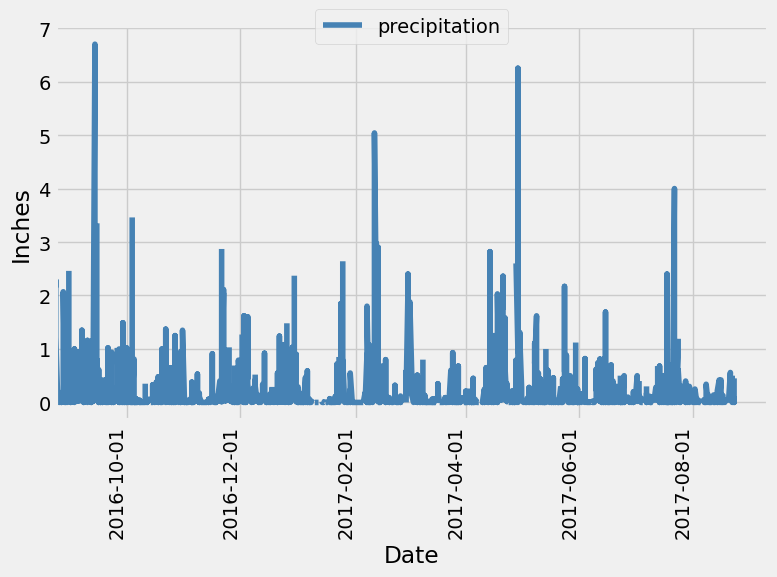

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date >= one_year_ago)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(precipitation_data, 
                                columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
precipitation_df.set_index('date', inplace=True)
# Get the start date for the x-axis
start_date = precipitation_df.index.min()

# Plotting using DataFrame's plot method
ax = precipitation_df['precipitation'].plot(figsize=(8, 6), color='steelblue')

# Set x-axis ticks at the start date and then at every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Ensure the x-axis includes the start date
ax.set_xlim(left=start_date)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='center', bbox_to_anchor=(0.5, 1))

plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['precipitation'].describe()

# Convert to DataFrame and rename the column to "precipitation"
precipitation_summary_df = precipitation_summary.to_frame(name='precipitation')
# Display the summary statistics
precipitation_summary_df

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(station.station))).all()

print(total_stations)

[(9,)]


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(measurement.station, 
                  func.count(measurement.station).label("count"))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .all()
)
# Display the results

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = (
    session.query(measurement.station)
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .first())[0]

temperature_data = (
  session.query(func.min(measurement.tobs).label("Lowest"),
                func.max(measurement.tobs).label("highest"),
                func.avg(measurement.tobs).label("Average")
                )

        .filter(measurement.station == most_active_station)
        .all()
 )
temperature_data

[(54.0, 85.0, 71.66378066378067)]

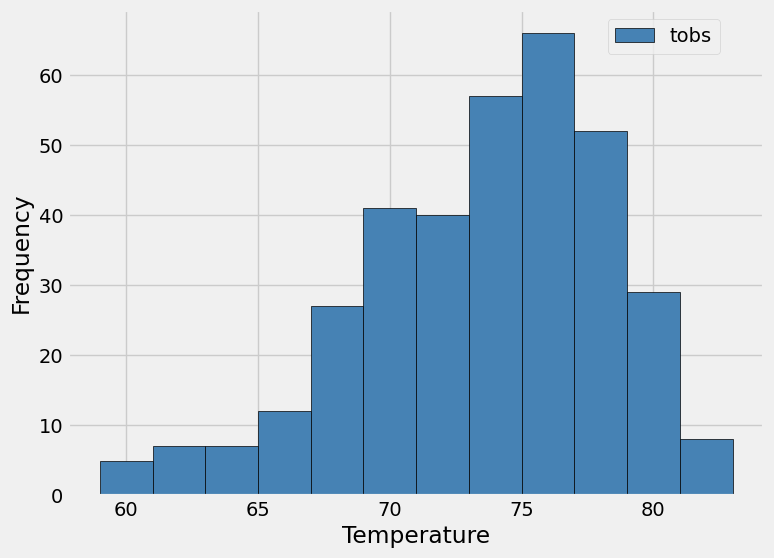

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
temperature_data = (
    session.query( measurement.tobs)
    .filter(measurement.station == most_active_station) 
    .filter(measurement.date >= one_year_ago)
    .all()
)

# Convert the query result into a list of temperatures
temperatures = [temp[0] for temp in temperature_data]

# Step 4: Plot the temperature data as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, color='steelblue', edgecolor='black', label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right', bbox_to_anchor=(0.95, 1))
plt.show()




# Close Session

In [26]:
# Close Session
session.close()